This is the model implemented from [this paper](https://www.pnas.org/content/pnas/105/40/15346.full.pdf).

In [903]:
using AgentBasedModels
using GLMakie
import GLMakie.GeometryBasics as gm
using Random
using Distributions
using CUDA

In [913]:
model = @agent(2,
            [vx,vy,theta,ω,d,l,m,I,Fx,Fy,W]::Local, #Local parameters
            [kn,γn,γt,μcc,μcw,β,βω]::Global,          #Global parameters
            contact::Identity,

            UpdateInteraction = begin
                #Compute distance between centers of mass
                dAux = sqrt((x_i-x_j)^2+(y_i-y_j)^2)
                if dAux > 0 && dAux < (l_i+l_j)/2
                    if abs(theta_i-theta_j)>0.001 #If not aligned
                        #Compute intersecting point virtual spheres
                        cxAux = (x_i-x_j)
                        cyAux = (y_i-y_j)
                        normAux = cos(theta_i)*sin(theta_j)-sin(theta_i)*cos(theta_j)
                        scaleAux = (-sin(theta_j)*cxAux+cos(theta_j)*cyAux)/normAux
                        pxAux = scaleAux*cos(theta_i)+x_i
                        pyAux = scaleAux*sin(theta_i)+y_i
                        
                        #Compute distance fron mass center
                        di = sqrt((x_i-pxAux)^2+(y_i-pyAux)^2)
                        if di <= l_i/2 #Cross point in cylinder
                            xiAux = 0.999*scaleAux*cos(theta_i)+x_i
                            yiAux = 0.999*scaleAux*sin(theta_i)+y_i
                            scaleAux = (-sin(theta_i)*cxAux+cos(theta_i)*cyAux)/normAux
                            xjAux = 0.999*scaleAux*cos(theta_j)+x_j
                            yjAux = 0.999*scaleAux*sin(theta_j)+y_j
                        else #Cross point outside cylinder
                            xiAux = l_i/2*cos(theta_i)+x_i
                            yiAux = l_i/2*sin(theta_i)+y_i
                            xjAux = l_j/2*cos(theta_j)+x_j
                            yjAux = l_j/2*sin(theta_j)+y_j
                        end
                    else #If aligned
                        xiAux = -0.49*(x_i-x_j)*cos(theta_i)+x_i
                        yiAux = -0.49*(y_i-y_j)*sin(theta_i)+y_i
                        xjAux = -0.49*(x_j-x_i)*cos(theta_j)+x_j
                        yjAux = -0.49*(y_j-y_i)*sin(theta_j)+y_j         
                    end

                    #Compute distance between virtual spheres
                    rij = sqrt((xiAux-xjAux)^2+(yiAux-yjAux)^2)
                    if rij > 0 && rij < d_i #If it is smaller than a diameter
                        #Compute auxiliar
                        δAux = d - rij
                        MeAux = m_i/2
                        #Compute interaction
                        nijx = (xiAux-xjAux)/rij
                        nijy = (yiAux-yjAux)/rij
                        vijx = (vx_i-vx_j)
                        vijy = (vy_i-vy_j)
                        #Compute inner product
                        vnAux = nijx*vijx+nijy*vijy
                        #Compute normal and tangential forces
                        FnAux = kn*δAux^1.5-γn*MeAux*δAux*vnAux
                        FtAux = -min(γt*MeAux*δAux^0.5,μcc*FnAux)
                        #Append to interaction forces
                        Fijx = FnAux*nijx #+ FtAux*(vijx-vnAux*nijx)
                        Fijy = FnAux*nijy #+ FtAux*(vijy-vnAux*nijx)
                        Fx_i += Fijx
                        Fy_i += Fijy
                        #Append radial forces
                        W += (xiAux-x_i)*Fijy - (yiAux-y_i)*Fijx
                    end
                end
            end,

            Equation = begin
                d_x = vx*dt
                d_y = vy*dt
                d_vx = -β*vx*dt+Fx/m*dt
                d_vy = -β*vy*dt+Fy/m*dt
                d_ω = W/(m*(d+l)^2/12+m*d^2)*dt-βω*ω*dt
                d_theta = ω*dt
            end,

            UpdateLocal = begin #Bound cells
                if theta < -π/2
                    theta += π
                elseif theta > π/2
                    theta -= π
                end
            end
    );

space = 

model = compile(model,integrator="Heun",platform="cpu");
#model.program

In [914]:
com = Community(model,N=1000);

com.kn = 1
com.γn = 1
com.γt = 1
com.μcc = 0.1
com.μcw = 0.8
com.β = 5
com.βω = 1

com.m .= 1
com.d .= 1
com.l .= 5;

com.x = rand(Uniform(-1,1),com.N)
com.y = rand(Uniform(-1,1),com.N)
com.theta = rand(Uniform(-π/2,π/2),com.N);

In [915]:
comt = model.evolve(com,dt=0.1,tMax=1000,dtSave=1);

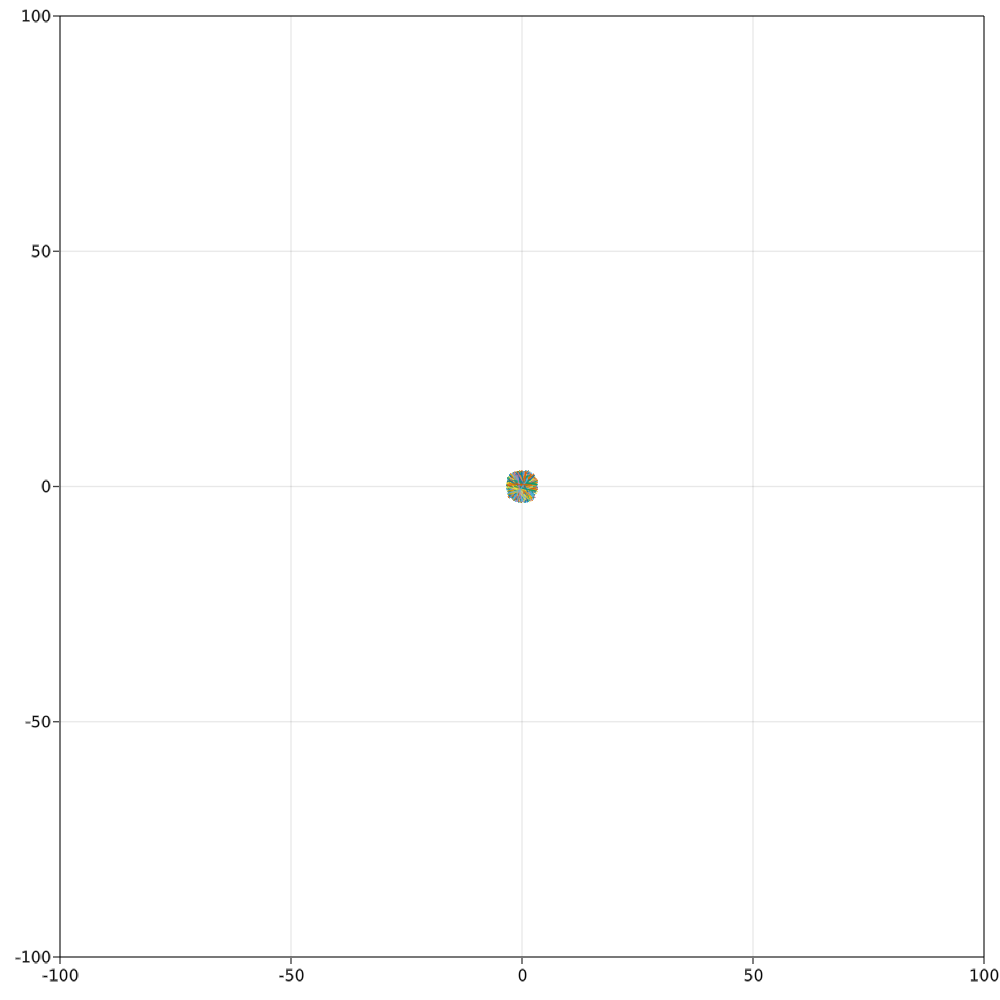

In [924]:
t = 1

fig = Figure(resolution=(1000,1000))
ax = Axis(fig[1,1])

# lx = (comt[t].l[1]/2+comt[t].d[1])*cos(comt[t].theta[1])
# ly = (comt[t].l[1]/2+comt[t].d[1])*sin(comt[t].theta[1])
# x = [comt[t].x[1]-lx, comt[t].x[1]+lx]
# y = [comt[t].y[1]-ly, comt[t].y[1]+ly]
# fig,ax = lines(x,y,linewidth=45*comt[t].d[1])
for i in range(1,comt[t].N,step=1)
    lx = (comt[t].l[i]/2)*cos(comt[t].theta[i])
    ly = (comt[t].l[i]/2)*sin(comt[t].theta[i])
    x = [comt[t].x[i]-lx, comt[t].x[i]+lx]
    y = [comt[t].y[i]-ly, comt[t].y[i]+ly]
    lines!(ax, x, y, linewidth=1*comt[t].d[i])
end

xlims!(ax,-100,100)
ylims!(ax,-100,100)

fig

In [566]:
model = @agent(2,
            [gₖ,gₗ,C,Vₖ₀,Vₗ₀,δₖ,δₗ,Sₜₕ,Vₜₕ,α₀,β,m,σ,γₛ,αₛ,η,ϵ,βₖ,V₀,αₑ,γₑ,E₀,q,Kₑ,αₖ,βₖ,Dₖ]::Global,  #Global parameters
            [V,n,S,Ki,E]::Local, #Bichemical variables
            [VK,VL,P]::Local,    #Biochemical parameters

            Ke::Medium,

            UpdateLocal = begin
                VK = Vₖ₀+δₖ*(Kₑ+K)       #Resting potential
                VL = Vₗ₀+δₗ*(Kₑ+K)       #Resting potential
                P = Ke^q/((E-E₀)^q+Kₑ^q) #Tumbling dynamics
            end;

            Equation = begin #Eqautions of the chemical
                d_V = (-gₖ*n^4*(V-Vₖ)-gₗ*(V-Vₗ))/(η*C)*dt         #Membrane potential
                d_n = (α₀S^m/(Sₜₕ^m+S^m)*(1-n)-β*n)/η*dt          #Potasium levels
                d_S = (αₛ*(Vₜₕ-V)/(exp((Vₜₕ-V)/σ)-1)-γₛ*S)/η*dt   #Stress
                d_Ki = (-ϵ*gₖ*n^4*(V-Vₖ)+βₖ*max((V₀-V),0))*dt     #Intrecellular potassium
                d_E = (-αₑ*V-γₑ*E)*dt                             #Energy
            end;

            UpdateMedium = begin
                ∂t_Ke = δx(x)+Dₖ*(Δx(Ke)+Δx(Ke)) #Difussion model
            end
)

LoadError: LoadError: MethodError: [0mCannot `convert` an object of type [92mExpr[39m[0m to an object of type [91mInt64[39m
[0mClosest candidates are:
[0m  convert(::Type{T}, [91m::LLVM.GenericValue[39m) where T<:Signed at /home/gabriel/.julia/packages/LLVM/XEOgl/src/execution.jl:27
[0m  convert(::Type{T}, [91m::LLVM.ConstantInt[39m) where T<:Signed at /home/gabriel/.julia/packages/LLVM/XEOgl/src/core/value/constant.jl:76
[0m  convert(::Type{T}, [91m::Base.TwicePrecision[39m) where T<:Number at twiceprecision.jl:250
[0m  ...
in expression starting at In[566]:1